# Tutorial 7: Recurrent Neural Networks and LSTM

Modified from CSC 2516

# Some useful functions
Run these code blocks before starting.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

np.random.seed(413)
torch.manual_seed(413)

def plot_extrap(ds, tps):
    plt.figure(figsize=(10, 5))
    plt.plot(tps[0], ds[0]['obs'], label='Train Region')
    plt.plot(tps[1], ds[0]['pred'], label='Unseen Extrapolation Region')

    plt.axvline(tps[0][-1])
    plt.title("Extrapolation Task")
    plt.xlabel('t')
    plt.legend(loc='upper left')
    plt.show()

def lv(x, t, params):
    dx = params[0] * x[0] - params[1] * x[0] * x[1]
    dy = params[2] * x[0] * x[1] - params[3] * x[1]
    return dx, dy

def lv_solve(tp, initial, params):
    return odeint(lv, initial, tp, args=((params,)))

def generate_lv_dataset(n, tp, i_range, p_range, noise_var=0.25):
    # Dataset is a list of trajectories. Each trajectories is a np array.
    dataset = []

    for _ in range(n):
        alpha = np.random.uniform(p_range[0][0], p_range[0][1])
        beta = np.random.uniform(p_range[1][0], p_range[1][1])
        delta = np.random.uniform(p_range[2][0], p_range[2][1])
        gamma = np.random.uniform(p_range[3][0], p_range[3][1])

        x = np.random.uniform(i_range[0][0], i_range[0][1])
        y = np.random.uniform(i_range[1][0], i_range[1][1])

        params = (alpha, beta, delta, gamma)
        traj = lv_solve(tp, (x, y), params)
        
        traj += np.random.randn(*traj.shape) * noise_var

        dataset.append(traj)
    
    return dataset

def visualize_lv(lv_tp, lv_data):
    fig, ax = plt.subplots(2, 2, figsize=(20, 6))

    for i in range(4):
        r = i // 2
        c = i % 2
        ax[r][c].plot(lv_tp, lv_data[i][:, 0], label="prey")
        ax[r][c].plot(lv_tp, lv_data[i][:, 1], label="predator")

        ax[r][c].scatter(lv_tp, lv_data[i][:, 0])
        ax[r][c].scatter(lv_tp, lv_data[i][:, 1])
        ax[r][c].legend(loc = "upper left")
    plt.show()

IRANGE = [[2, 4], [0.5, 1]]
PRANGE = [[0.35, 0.5], [0.15, 0.25], [0.05, 0.1], [0.25, 0.55]]


# Time Series Prediction Task

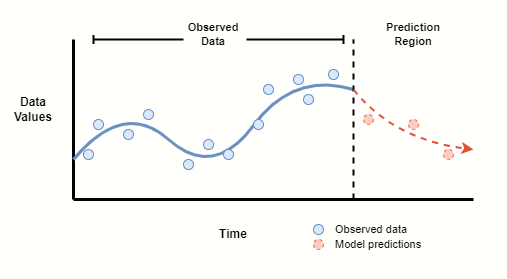

We apply the RNN in a manner known as autoregressive prediction for this task.
When input data is available, we update the RNN normally:

$$y[t], h[t] = \text{RNNCell}(x[t], h[t-1])$$

In the prediction region, where input data is unavailable, the RNN update is performed using the previous output:

$$y[t], h[t] = \text{RNNCell}(y[t-1], h[t-1])$$

This is visually shown below:

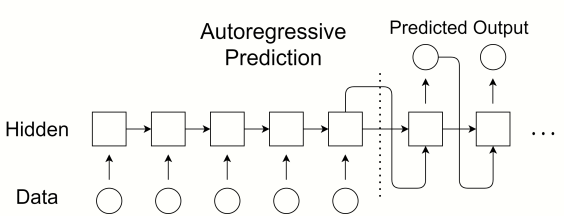

## Example: Predator-Prey Relationships

Predator-Prey Relationships: Lotka-Volterra Model

$$ \begin{align}
\frac{dx}{dt} &= \alpha x - \beta x y \hspace{1em} [\text{prey}] \\
\frac{dy}{dt} &= \delta x y - \gamma y \hspace{1em} [\text{predator}]
\end{align}
$$

The parameters $\alpha, \beta, \delta, \gamma$ represent the rate of predation, reproduction, etc., and affect the shape and frequency of these curves. To generate synthetic data, we will randomly sample the parameters, and then solve for the equations.

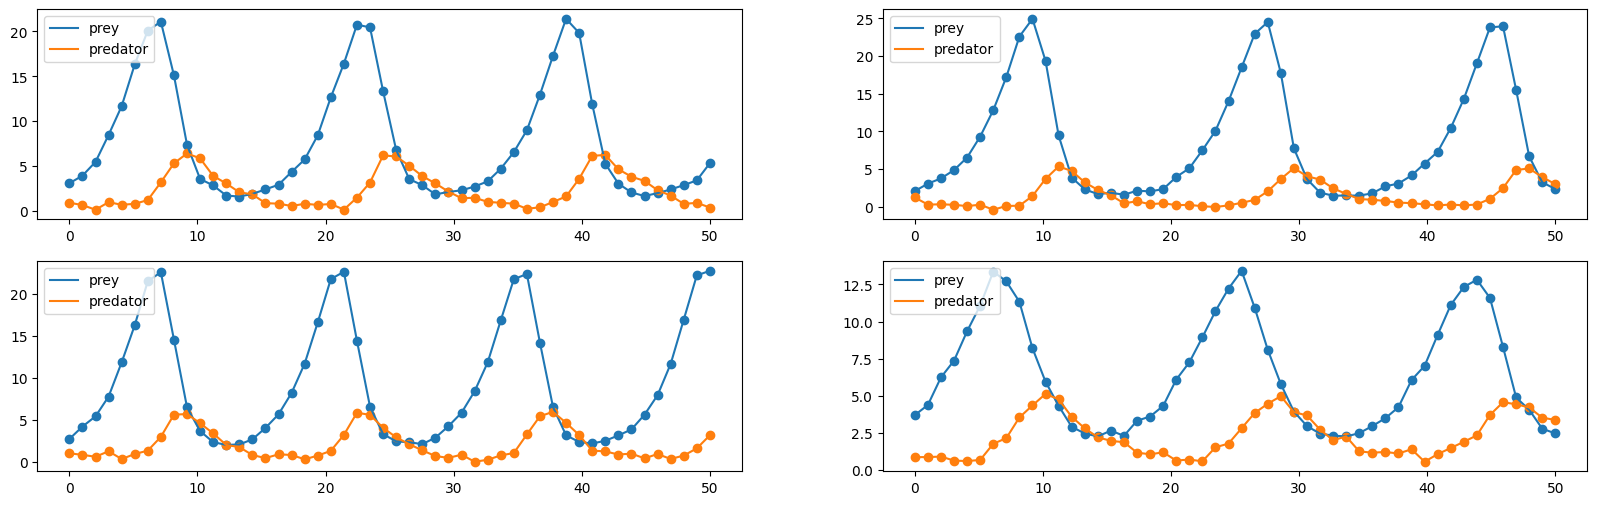

In [2]:
lv_tp = np.linspace(0, 50, 50)
lv_data = generate_lv_dataset(1500, lv_tp, IRANGE, PRANGE, noise_var=0.25)

visualize_lv(lv_tp, lv_data)  # draw the first four trajectories in lv_data

Splitting the data:

- Train on first 50%
- Validate on 50% to 75%
- Test on 75% to 100%



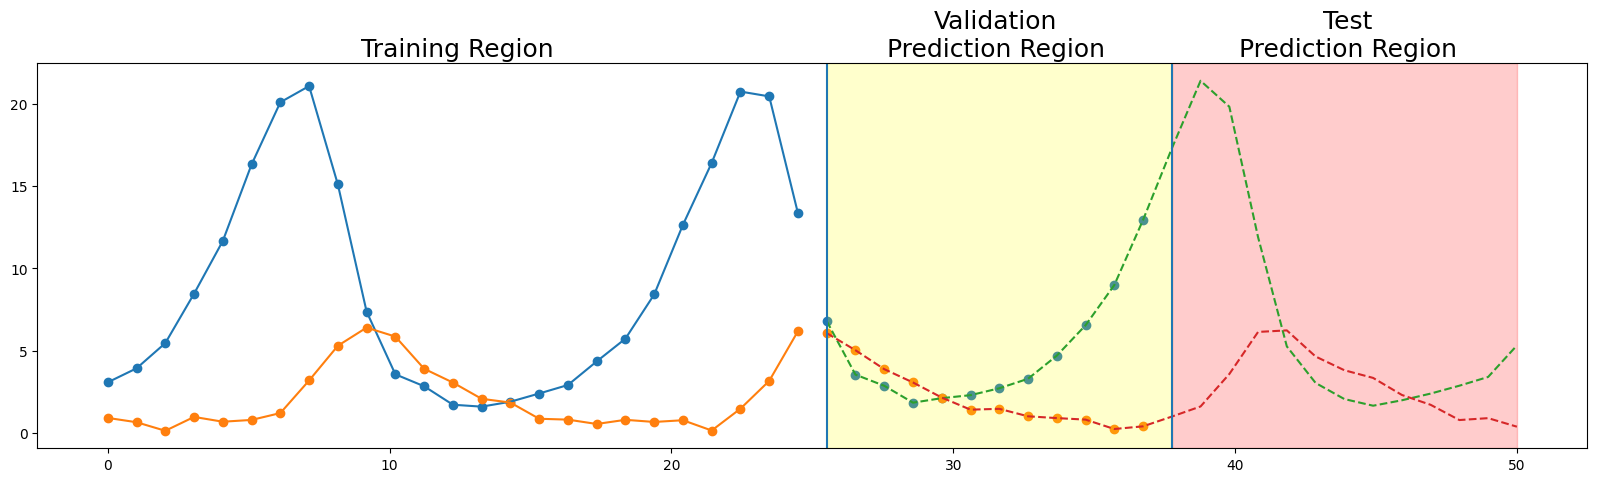

In [3]:
plt.figure(figsize=(20, 5))

val_split = int(0.5*len(lv_tp))
test_split = int(0.75*len(lv_tp))

plt.plot(lv_tp[:val_split], lv_data[0][:val_split])
plt.plot(lv_tp[val_split:], lv_data[0][val_split:], ls='--')

plt.scatter(lv_tp[:test_split], lv_data[0][:test_split, 0])
plt.scatter(lv_tp[:test_split], lv_data[0][:test_split, 1])

plt.axvline(lv_tp[val_split])
plt.axvline(lv_tp[test_split])

plt.axvspan(lv_tp[val_split], lv_tp[test_split], color='yellow', alpha=0.2)
plt.axvspan(lv_tp[test_split], lv_tp[-1], color='red', alpha=0.2)

d_max = max(lv_data[0][:, 0]) + 1.5
plt.text(9, d_max, "Training Region", fontsize=18)
plt.text(31.5, d_max, "Validation\nPrediction Region", fontsize=18, ha='center')
plt.text(44, d_max, "Test\nPrediction Region", fontsize=18, ha='center')
plt.show()

Let's preprare the data for PyTorch. We'll also implement the split process here.

In [4]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class LVData(Dataset):
    def __init__(self, data, tp):
        self.data = data
        self.tp = tp

    def __getitem__(self, idx):
        traj = self.data[idx]

        # Individual trajectories are split into train/val/test regions
        val_split = int(0.5 * len(traj))
        test_split = int(0.75 * len(traj))

        train_traj = traj[:val_split]
        val_traj = traj[val_split:test_split]
        test_traj = traj[test_split:]

        train_tp = self.tp[:val_split]
        val_tp = self.tp[val_split:test_split]
        test_tp = self.tp[test_split:]

        return train_traj, val_traj, test_traj, train_tp, val_tp, test_tp

    def __len__(self):
        return len(self.data)

lv_data_tensor = torch.Tensor(np.array(lv_data)).to(device)
lv_tp_tensor = torch.Tensor(np.array(lv_tp)).to(device)

# Splitting data into training / validation / test trajectories
lv_data_tv, lv_data_test = train_test_split(lv_data_tensor, test_size=0.1)
lv_data_train, lv_data_val = train_test_split(lv_data_tv, test_size=0.1)

# Create PyTorch data structures
lv_train_set = LVData(lv_data_train, lv_tp_tensor)
lv_val_set = LVData(lv_data_val, lv_tp_tensor)
lv_test_set = LVData(lv_data_test, lv_tp_tensor)

lv_train_loader = DataLoader(lv_train_set, batch_size=32, shuffle=True)
lv_val_loader = DataLoader(lv_val_set, batch_size=256, shuffle=False)
lv_test_loader = DataLoader(lv_test_set, batch_size=256, shuffle=False)

# RNNs

## What problems to RNNs try to solve?

- Predicting next value of a sequence
- Sequence classification
- Forecasting

## Advantages of RNNs

- Non-linear hidden state
- Has some form of memory to represent long term dependencies
- Shared weights, so sequences can be arbitrarily long

## Simple RNN Architecture

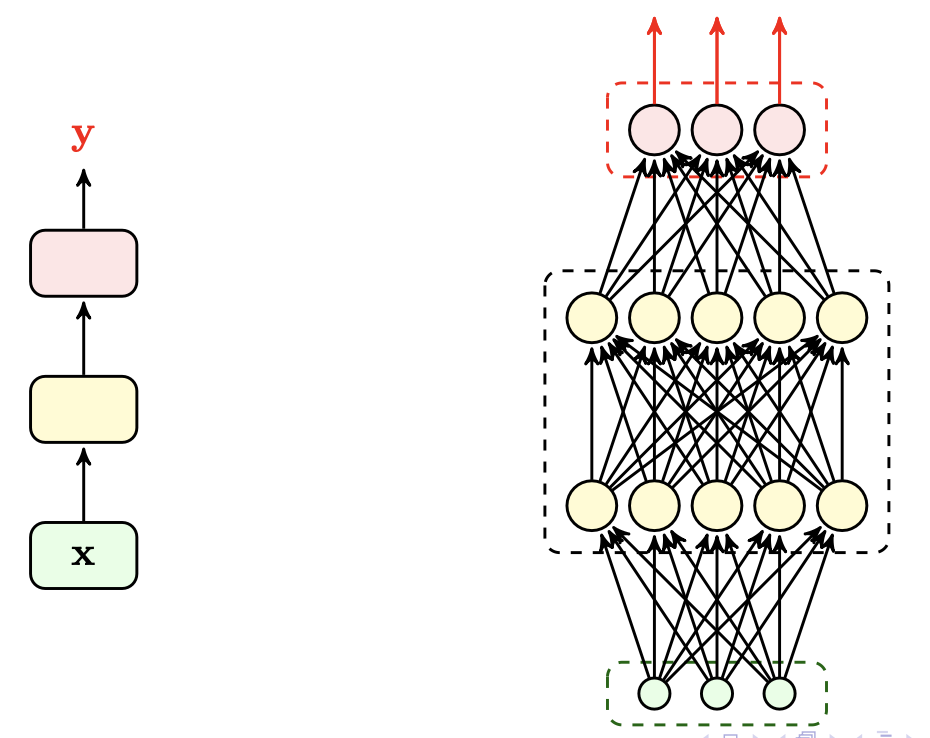

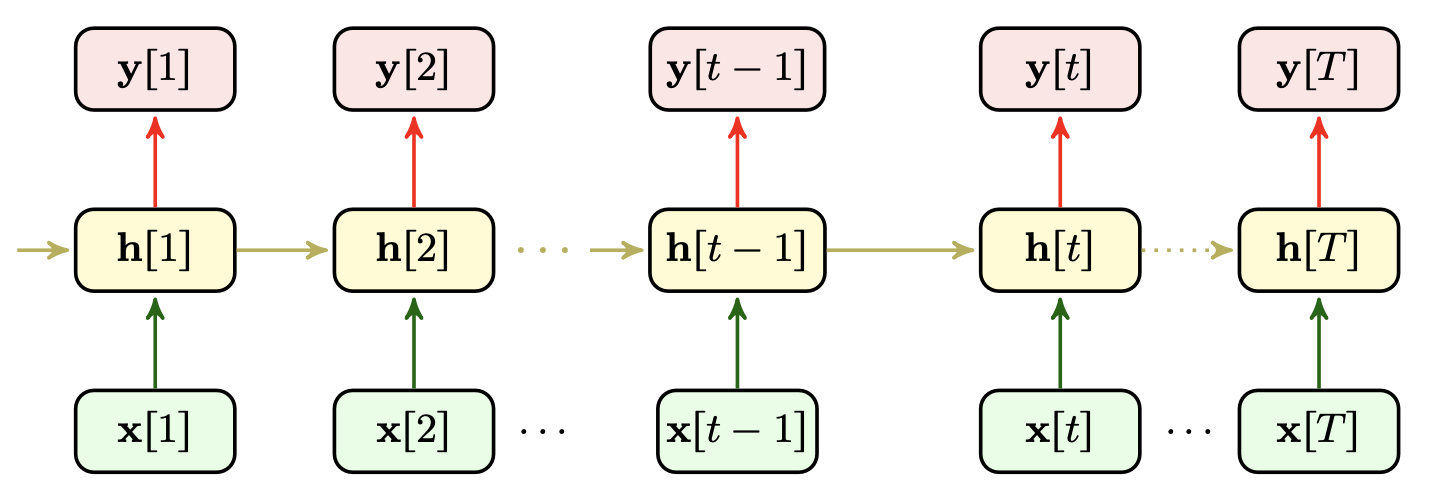

For a single point in time we define the following relations:

$$y[t] = f(W_2 h[t])$$
$$h[t] = f(W_1 x[t] + W_m h[t-1])$$

## RNN Implementation


Let's build a simple RNN using these relations:

$$\begin{align}h[t] &= \tanh(W_2 x[t] +W_{m} h[t-1])\\
y[t] &= \text{softmax}(W_{1} h[t]) \end{align}$$


Let's build a module that we can use to build up the big RNN later.

$$y[t], h[t] = \text{RNNCell}(x[t], h[t-1])$$

This process starts at $t=0$, where $h[0]$ is randomly initialized, and continues for the length of the sequence.  
The variable $y[t]$ is the output for that time step.

In [139]:
class SimpleRNNCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleRNNCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        # Weights for the input and hidden state
        self.W_x = nn.Linear(input_dim, hidden_dim)
        self.W_h = nn.Linear(hidden_dim, hidden_dim)

        # Activation function
        self.activation = nn.Tanh()

    def forward(self, x, h_prev):
        """
        x: Input at the current time step, shape (B, input_dim)
        h_prev: Hidden state from the previous time step, shape (B, hidden_dim)
        
        Returns:
        h_next: Updated hidden state, shape (B, hidden_dim)
        """
        h_next = self.activation(self.W_x(x) + self.W_h(h_prev))
        return h_next


class SimpleRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleRNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn_cell = SimpleRNNCell(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        x: Input sequence, shape (B, T, input_dim)
        
        Returns:
        outputs: Output for each time step, shape (B, T, output_dim)
        final_hidden: Final hidden state, shape (B, hidden_dim)
        """
        batch_size, seq_length, _ = x.size()
        h = self.init_hidden(batch_size).to(x.device)

        outputs = []

        for t in range(seq_length):
            h = self.rnn_cell(x[:, t, :], h)  # Get hidden state at current time step
            outputs.append(h.unsqueeze(1))  # Add a time dimension

        # Concatenate along the time dimension to get shape (B, T, hidden_dim)
        outputs = torch.cat(outputs, dim=1)

        # Map hidden states to output space for each time step
        outputs = self.output_layer(outputs)  # Shape (B, T, output_dim)

        return outputs, h

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state with normal distribution.
        """
        return torch.randn((batch_size, self.hidden_dim))

Now we build our larger RNN module using this cell and use it repeatedly.

In [140]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

# Initialize the RNN model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = SimpleRNN(input_dim=2, hidden_dim=32, output_dim=2).to('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = Adam(list(rnn_model.parameters()) + list(output_net.parameters()), lr=3e-4)

# Main training loop
num_epochs = 41
for epoch in range(num_epochs):
    rnn_model.train()  # Set the model to training mode
    total_train_loss = 0

    for batch in lv_train_loader:
        optimizer.zero_grad()
    
        # Unpack the batch data and move to device
        train_region, val_region, _, train_tp, val_tp, _ = batch
        train_region = train_region.to(device)
        val_region = val_region.to(device)
    
        # Run the model forward to get the hidden states
        predictions, _ = rnn_model(train_region)  # Shape should be (B, T, H)
        # print(predictions.shape)
   
    
        # Compute training loss
        train_loss = F.mse_loss(predictions, train_region)
        train_loss.backward()
        optimizer.step()
    
        total_train_loss += train_loss.item()

    # Evaluate validation loss at specific intervals
    if epoch % 10 == 0:
        rnn_model.eval()  # Set the model to evaluation mode
        total_val_loss = 0
        with torch.no_grad():
            for v_batch in lv_val_loader:
                train_region, val_region, _, train_tp, val_tp, _ = v_batch
                train_region = train_region.to(device)
                val_region = val_region.to(device)

                predictions, _ = rnn_model(train_region)
                predictions = predictions[:, :val_region.size(1), :]

                val_loss = F.mse_loss(predictions, val_region)
                total_val_loss += val_loss.item()

        avg_train_loss = total_train_loss / len(lv_train_loader)
        avg_val_loss = total_val_loss / len(lv_val_loader)
        print(f"Epoch {epoch}: Train Loss {avg_train_loss:.4f}, Val Loss {avg_val_loss:.4f}")

# # Plot the results after training
# with torch.no_grad():
#     train_region = train_region.cpu()
#     train_tp = train_tp.cpu()
#     val_tp = val_tp.cpu()
#     val_region = val_region.cpu()
#     predictions = predictions.cpu()

#     plt.plot(train_tp[0], train_region[0], label="Training")
#     plt.scatter(val_tp[0], val_region[0, :, 0], label="Validation Actual")
#     plt.scatter(val_tp[1], val_region[0, :, 1], label="Validation Actual")
#     plt.plot(val_tp[0], predictions[0, :, 0], label="Validation Prediction", linestyle='--')
#     plt.plot(val_tp[1], predictions[0, :, 1], label="Validation Prediction", linestyle='--')

#     plt.axvline(train_tp[0, -1])
#     d_max = max(train_region[0].max(), val_region[0].max(), predictions[0].max())
#     plt.text(9, d_max - 1, "Training Region", fontsize=12)
#     plt.text(29, d_max - 1, "Val Region", fontsize=12)

#     plt.legend()
#     plt.show()


Epoch 0: Train Loss 37.2090, Val Loss 22.0870
Epoch 10: Train Loss 15.6917, Val Loss 13.1899
Epoch 20: Train Loss 8.9508, Val Loss 16.2386
Epoch 30: Train Loss 5.6030, Val Loss 20.0198
Epoch 40: Train Loss 3.7290, Val Loss 23.3883


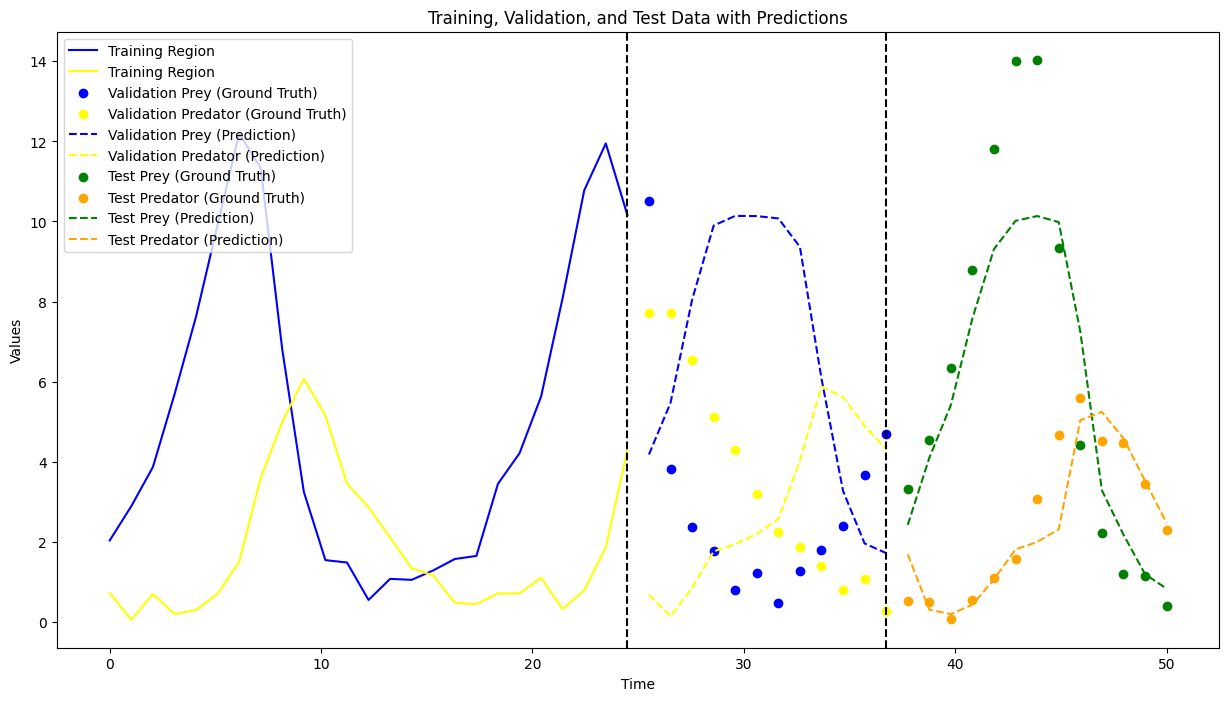

In [141]:
import matplotlib.pyplot as plt

# Evaluate on validation and test sets, and collect predictions for plotting
def evaluate_and_plot(rnn_model, lv_train_loader, lv_val_loader, lv_test_loader):
    rnn_model.eval()  # Set the model to evaluation mode
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Collect data for plotting
    val_predictions_list, val_actual_list, val_tp_list = [], [], []
    test_predictions_list, test_actual_list, test_tp_list = [], [], []

    # Validation data collection
    with torch.no_grad():
        for val_batch in lv_val_loader:
            train_region, val_region, _, train_tp, val_tp, _ = val_batch
            train_region = train_region.to(device)
            val_region = val_region.to(device)

            # Forward pass
            val_predictions, _ = rnn_model(train_region)
            val_predictions = val_predictions[:, :val_region.size(1), :]

            # Collect data for plotting
            val_predictions_list.append(val_predictions.cpu())
            val_actual_list.append(val_region.cpu())
            val_tp_list.append(val_tp.cpu())

    # Test data collection
    with torch.no_grad():
        for test_batch in lv_test_loader:
            train_region, _, test_region, train_tp, _, test_tp = test_batch
            train_region = train_region.to(device)
            test_region = test_region.to(device)

            # Forward pass
            test_predictions, _ = rnn_model(train_region)
            test_predictions = test_predictions[:, :test_region.size(1), :]

            # Collect data for plotting
            test_predictions_list.append(test_predictions.cpu())
            test_actual_list.append(test_region.cpu())
            test_tp_list.append(test_tp.cpu())

    # Plot the results
    plt.figure(figsize=(15, 8))

    # Plot training data (use the first batch)
    for train_batch in lv_train_loader:
        train_region, _, _, train_tp, _, _ = train_batch
        train_region = train_region.cpu()
        train_tp = train_tp.cpu()
        plt.plot(train_tp[0], train_region[0, :, 0], label="Training Region", color='blue')
        plt.plot(train_tp[0], train_region[0, :, 1], label="Training Region", color='yellow')

        
        break  # Plot only the first batch for training data


    # Add a vertical line to indicate the end of the training region
    plt.axvline(train_tp[0, -1], color='black', linestyle='--')
    
    # Plot validation data (use the first batch)
    val_region = val_actual_list[0]  # Ground truth
    val_predictions = val_predictions_list[0]  # Predictions
    val_tp = val_tp_list[0]

    plt.scatter(val_tp[0], val_region[0, :, 0], label="Validation Prey (Ground Truth)", color='blue')
    plt.scatter(val_tp[0], val_region[0, :, 1], label="Validation Predator (Ground Truth)", color='yellow')
    plt.plot(val_tp[0], val_predictions[0, :, 0], linestyle='--', label="Validation Prey (Prediction)", color='blue')
    plt.plot(val_tp[0], val_predictions[0, :, 1], linestyle='--', label="Validation Predator (Prediction)", color='yellow')
    
    # Add a vertical line to indicate the end of the training region
    plt.axvline(val_tp[0, -1], color='black', linestyle='--')
    
    # Plot test data (use the first batch)
    test_region = test_actual_list[0]  # Ground truth
    test_predictions = test_predictions_list[0]  # Predictions
    test_tp = test_tp_list[0]

    plt.scatter(test_tp[0], test_region[0, :, 0], label="Test Prey (Ground Truth)", color='green')
    plt.scatter(test_tp[0], test_region[0, :, 1], label="Test Predator (Ground Truth)", color='orange')
    plt.plot(test_tp[0], test_predictions[0, :, 0], linestyle='--', label="Test Prey (Prediction)", color='green')
    plt.plot(test_tp[0], test_predictions[0, :, 1], linestyle='--', label="Test Predator (Prediction)", color='orange')



    # Final plot adjustments
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.title("Training, Validation, and Test Data with Predictions")
    plt.legend()
    plt.show()

# Run the evaluation and plotting function
evaluate_and_plot(rnn_model, lv_train_loader, lv_val_loader, lv_test_loader)


# LSTMs

Source: https://colah.github.io/posts/2015-08-Understanding-LSTMs/



### LSTM Architecture
![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

## LSTM Walkthrough

### LSTM Cell States
![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png)

### Why are they called gates?
![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-gate.png)

### Forget Gate
![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-f.png)

### Input Gate $i_t$ and Update Gate $\tilde{C}_t$
![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-i.png)

### Modifying Cell Information
![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-C.png)

### Output Gate
![](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-focus-o.png)

## LSTM Implementation

The LSTM addresses the vanishing gradient problem through the inclusion of a cell state. This cell state can only be updated through several gates, meaning it can more easily preserve long-term information.

Each LSTM update is represented by the below equations (biases omitted):

$$ \begin{align}
f_t &= \sigma(W_{fi} x_t + W_{fh} h_{t-1}) \hspace{1em} [\text{Forget gate}] \\
i_t &= \sigma(W_{ii} x_t + W_{ih} h_{t-1}) \hspace{1em} [\text{Input gate}] \\
\tilde{C}_t &= \tanh(W_{gi} x_t + W_{gh} h_{t-1}) \hspace{1em} [\text{Update gate}] \\
o_t &= \sigma(W_{oi} x_t + W_{oh} h_{t-1}) \hspace{1em} [\text{Output gate}] \\
C_t &= C_{t-1} \odot f_t + i_t \odot \tilde{C}_t \\
h_t &= \tanh(C_t) \odot o_t
\end{align}
$$

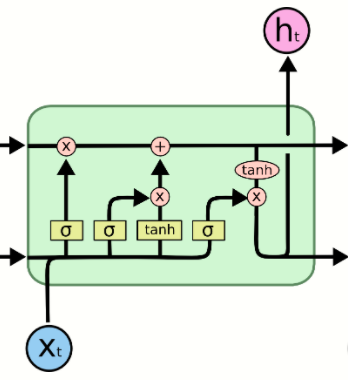

In [142]:
class OurLSTMCell(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.forget_gate_i = nn.Linear(in_dim, hid_dim)
        self.forget_gate_h = nn.Linear(hid_dim, hid_dim)

        self.input_gate_i = nn.Linear(in_dim, hid_dim)
        self.input_gate_h = nn.Linear(hid_dim, hid_dim)

        self.update_gate_i = nn.Linear(in_dim, hid_dim)
        self.update_gate_h = nn.Linear(hid_dim, hid_dim)

        self.out_gate_i = nn.Linear(in_dim, hid_dim)
        self.out_gate_h = nn.Linear(hid_dim, hid_dim)

        self.sig = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, hid_state, cell_state):
        fg = self.sig(self.forget_gate_i(x) + self.forget_gate_h(hid_state))
        ig = self.sig(self.input_gate_i(x) + self.input_gate_h(hid_state))
        ug = self.tanh(self.update_gate_i(x) + self.update_gate_h(hid_state))
        og = self.sig(self.out_gate_i(x) + self.out_gate_h(hid_state))

        cell_state = cell_state * fg + ig * ug
        hid_state = og * self.tanh(cell_state)

        return hid_state, cell_state

The LSTM is pretty much identical to the RNN in terms of its iteration.  
The only difference is that the cell state much be initialized in addition to the hidden state.

In [143]:
class OurLSTM(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super().__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.LSTMCell = OurLSTMCell(in_dim, hid_dim, out_dim)

    def forward(self, x):
        """
            X has shape B x T x D where
                B = Batch size
                T = Length of sequence
                D = Number of features
        """
        h = self.init_hidden(x.shape[0]).to(x.device)
        c = self.init_cell(x.shape[0]).to(x.device)

        out_arr = []

        for t in range(x.shape[1]):
            h, c = self.LSTMCell(x[:, t, :], h, c)
            out_arr.append(h.unsqueeze(1))

        return torch.cat(out_arr, dim=1), (h, c)

    def init_hidden(self, batch_size):
        return torch.randn((batch_size, self.hid_dim))

    def init_cell(self, batch_size):
        return torch.randn((batch_size, self.hid_dim))

In [144]:
class LSTMPredictor(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim=None):
        super().__init__()
        if out_dim is None:
            out_dim = in_dim

        self.out_net = nn.Linear(hid_dim, out_dim)
        self.lstm = OurLSTM(in_dim, hid_dim, out_dim)

    def forward(self, x):
        # The LSTM returns the output for each timesteps in a (B x T x H) array
        # The other output is a tuple of the final hidden and cell states.
        # For the forward function, we will just pass the values through.
        out, (h, c) = self.lstm(x)
        return out, (h, c)

    def predict(self, x, K):

        """ 
        This method implements autoregressive prediction.

        K: the number of steps we want to predict.     

        To predict unseen data, we use the last LSTM output (t=-1) as the input for 
        the next timestep. Recall, `out` is (B x T x H), meaning we need to
        use a linear layer to map to the output dimension. This must be 
        repeated for all outputs to get our predictions.
        """
        
        out, (h, c) = self.lstm(x)
        predictions = []

        last_output = out[:, -1:, :]  # Shape: (B, 1, H)
        next_input = self.out_net(last_output)

        for _ in range(K):
            h, c = self.lstm.LSTMCell(next_input.squeeze(1), h, c)
            pred = self.out_net(h)
            predictions.append(pred.unsqueeze(1))
            next_input = pred.unsqueeze(1)

        return torch.cat(predictions, dim=1)

## LSTM Training & Testing

#### Training
Now we train on the data. We want to minimize the mean squared error (MSE) between predicted and actual populations.  
Also note that adaptive optimizers, like Adam, are believed to work better on recurrent architectures.

Epoch 0: Train Loss 22.365747853329307, Val Loss 19.388063430786133
Epoch 10: Train Loss 4.322840370629963, Val Loss 3.6518335342407227
Epoch 20: Train Loss 1.4876447100388377, Val Loss 1.1892019510269165
Epoch 30: Train Loss 0.8448207943063033, Val Loss 0.6332571506500244
Epoch 40: Train Loss 0.5834160454963383, Val Loss 0.43515533208847046


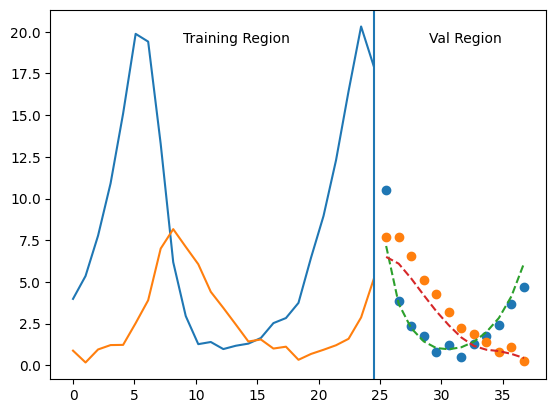

In [145]:
from torch.optim import Adam

lstm = LSTMPredictor(2, 100).to(device)
opt = Adam(lstm.parameters(), lr=3e-4)

# Main training loop
for epoch in range(41):
    t_loss_sum = 0
    for batch in lv_train_loader:
        opt.zero_grad()
        train_region, val_region, _, train_tp, val_tp, _ = batch

        # Fit model on training region, predict in validation region
        n_steps_pred = len(val_region[0])
        pred = lstm.predict(train_region, n_steps_pred)

        # Take a squared loss between predicted vs actual
        train_loss = nn.MSELoss()(pred, val_region)

        train_loss.backward()
        opt.step()

        t_loss_sum += train_loss.item()

    # Evaluate validation loss at specific intervals
    if epoch % 10 == 0:
        # Make sure to not compute gradients when computing validation loss
        with torch.no_grad():
            v_loss_sum = 0
            for v_batch in lv_val_loader:
                train_region, val_region, _, train_tp, val_tp, _ = v_batch

                n_steps_pred = len(val_region[0])
                pred = lstm.predict(train_region, n_steps_pred)

                val_loss = nn.MSELoss()(pred, val_region)
                v_loss_sum += val_loss.item()

        avg_t_loss = t_loss_sum / len(lv_train_loader)
        avg_v_loss = v_loss_sum / len(lv_val_loader)
        out_msg = "Epoch {}: Train Loss {}, Val Loss {}"
        print(out_msg.format(epoch, avg_t_loss, avg_v_loss))

with torch.no_grad():
    plt.plot(train_tp.cpu()[0], train_region.cpu()[0])
    plt.scatter(val_tp.cpu()[0], val_region.cpu()[0][:, 0])
    plt.scatter(val_tp.cpu()[0], val_region.cpu()[0][:, 1])
    plt.plot(val_tp.cpu()[0], pred.cpu()[0], ls='--')
    plt.axvline(train_tp.cpu()[0, -1])
    d_max = max(torch.max(val_region[0]), torch.max(train_region[0]))
    d_max = max(d_max, torch.max(pred[0]))

    plt.text(9, d_max-1, "Training Region")
    plt.text(29, d_max-1, "Val Region")
    plt.show()

### Testing

Let's preprare the data for PyTorch. We'll also implement the split process here.

Test Loss: 4.214721202850342


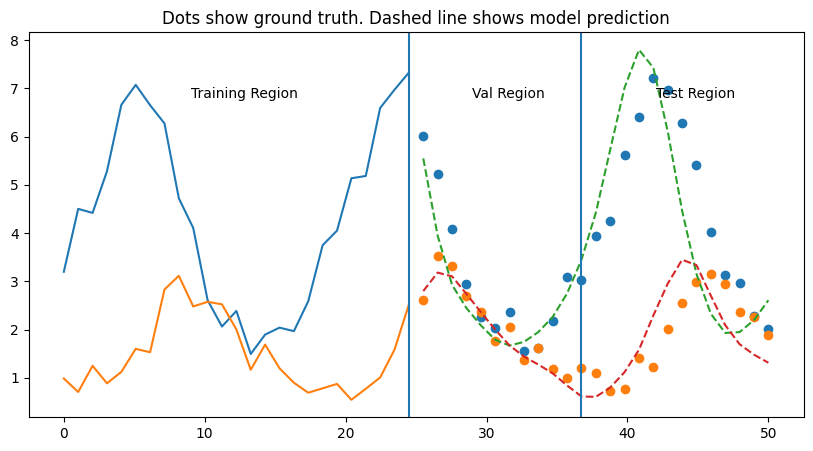

In [147]:
test_loss_sum = 0

for batch in lv_test_loader:
    opt.zero_grad()
    train_region, val_region, test_region, train_tp, val_tp, test_tp = batch

    val_len = len(val_region[0])
    test_len = len(test_region[0])

    # Can set arbitrarily long sequence
    n_steps_pred = val_len + test_len
    pred = lstm.predict(train_region, n_steps_pred)

    val_pred = pred[:, :val_len]
    test_pred = pred[:, val_len:val_len+test_len]
    test_loss = nn.MSELoss()(test_pred, test_region)

    test_loss_sum += test_loss

print("Test Loss: {}".format(test_loss_sum / len(lv_test_loader)))

# Plotting result
with torch.no_grad():
    ground_truth = torch.cat([val_region[0], test_region[0]], axis=0)
    cat_tp = torch.cat([val_tp[0], test_tp[0]])

    cat_pred = torch.cat([val_pred[0], test_pred[0]])

    plt.figure(figsize=(10, 5))
    plt.plot(train_tp.cpu()[0], train_region.cpu()[0])
    plt.scatter(cat_tp.cpu(), ground_truth.cpu()[:, 0])
    plt.scatter(cat_tp.cpu(), ground_truth.cpu()[:, 1])

    plt.plot(cat_tp.cpu(), cat_pred.cpu(), ls='--')
    plt.axvline(train_tp.cpu()[0][-1])
    plt.axvline(val_tp.cpu()[0][-1])

    d_max = max(torch.max(cat_pred), torch.max(ground_truth))
    plt.text(9, d_max-1, "Training Region")
    plt.text(29, d_max-1, "Val Region")
    plt.text(42, d_max-1, "Test Region")
    plt.title("Dots show ground truth. Dashed line shows model prediction")
    plt.show()

### Play with short-sight training

What if training on only the next one or two time points? If the model is trained in a short-sight way, does it still get the pattern?



Epoch 0: Train Loss 32.68911256288227, Val Loss 18.30113410949707
Epoch 10: Train Loss 3.8725645102952657, Val Loss 5.557899475097656
Epoch 20: Train Loss 1.3896887365140413, Val Loss 4.692287921905518
Epoch 30: Train Loss 0.7411646493955663, Val Loss 4.4004950523376465
Epoch 40: Train Loss 0.5155767249433618, Val Loss 4.106750965118408


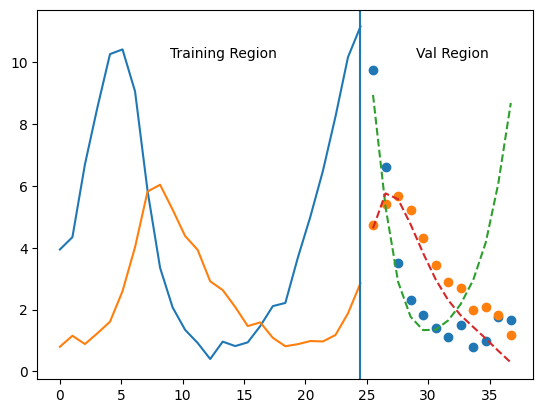

In [14]:



from torch.optim import Adam

lstm = LSTMPredictor(2, 100).to(device)
opt = Adam(lstm.parameters(), lr=3e-4)

# Main training loop
for epoch in range(41):
    t_loss_sum = 0
    for batch in lv_train_loader:
        opt.zero_grad()
        train_region, val_region, _, train_tp, val_tp, _ = batch

        n_steps_pred = 2  # len(val_region[0]), -------------- CHANGED THIS LINE
        # Fit model on training region, predict in validation region
        pred = lstm.predict(train_region, n_steps_pred)

        # Take a squared loss between predicted vs actual
        train_loss = nn.MSELoss()(pred, val_region[:, :2])  # ------------- CHANGED THIS LINE

        train_loss.backward()
        opt.step()

        t_loss_sum += train_loss.item()

    # Evaluate validation loss at specific intervals
    if epoch % 10 == 0:
        # Make sure to not compute gradients when computing validation loss
        with torch.no_grad():
            v_loss_sum = 0
            for v_batch in lv_val_loader:
                train_region, val_region, _, train_tp, val_tp, _ = v_batch

                n_steps_pred = len(val_region[0])
                pred = lstm.predict(train_region, n_steps_pred)

                val_loss = nn.MSELoss()(pred, val_region)
                v_loss_sum += val_loss.item()

        avg_t_loss = t_loss_sum / len(lv_train_loader)
        avg_v_loss = v_loss_sum / len(lv_val_loader)
        out_msg = "Epoch {}: Train Loss {}, Val Loss {}"
        print(out_msg.format(epoch, avg_t_loss, avg_v_loss))

with torch.no_grad():
    plt.plot(train_tp.cpu()[0], train_region.cpu()[0])
    plt.scatter(val_tp.cpu()[0], val_region.cpu()[0][:, 0])
    plt.scatter(val_tp.cpu()[0], val_region.cpu()[0][:, 1])
    plt.plot(val_tp.cpu()[0], pred.cpu()[0], ls='--')
    plt.axvline(train_tp.cpu()[0, -1])
    d_max = max(torch.max(val_region[0]), torch.max(train_region[0]))
    d_max = max(d_max, torch.max(pred[0]))

    plt.text(9, d_max-1, "Training Region")
    plt.text(29, d_max-1, "Val Region")
    plt.show()

Test Loss: 15.697380065917969


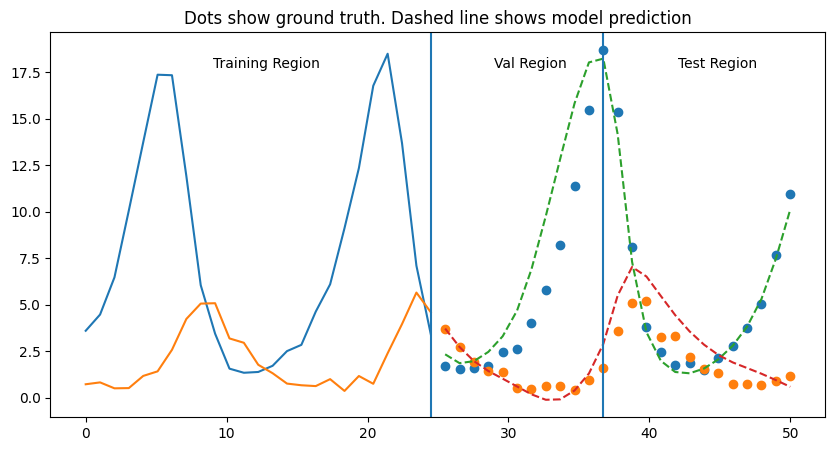

In [15]:
test_loss_sum = 0

for batch in lv_test_loader:
    opt.zero_grad()
    train_region, val_region, test_region, train_tp, val_tp, test_tp = batch

    val_len = len(val_region[0])
    test_len = len(test_region[0])

    # Can set arbitrarily long sequence during evaluation. Can be different from training length.
    n_steps_pred = val_len + test_len
    pred = lstm.predict(train_region, n_steps_pred)

    val_pred = pred[:, :val_len]
    test_pred = pred[:, val_len:val_len+test_len]
    test_loss = nn.MSELoss()(test_pred, test_region)

    test_loss_sum += test_loss

print("Test Loss: {}".format(test_loss_sum / len(lv_test_loader)))

# Plotting result
with torch.no_grad():
    ground_truth = torch.cat([val_region[0], test_region[0]], axis=0)
    cat_tp = torch.cat([val_tp[0], test_tp[0]])

    cat_pred = torch.cat([val_pred[0], test_pred[0]])

    plt.figure(figsize=(10, 5))
    plt.plot(train_tp.cpu()[0], train_region.cpu()[0])
    plt.scatter(cat_tp.cpu(), ground_truth.cpu()[:, 0])
    plt.scatter(cat_tp.cpu(), ground_truth.cpu()[:, 1])

    plt.plot(cat_tp.cpu(), cat_pred.cpu(), ls='--')
    plt.axvline(train_tp.cpu()[0][-1])
    plt.axvline(val_tp.cpu()[0][-1])

    d_max = max(torch.max(cat_pred), torch.max(ground_truth))
    plt.text(9, d_max-1, "Training Region")
    plt.text(29, d_max-1, "Val Region")
    plt.text(42, d_max-1, "Test Region")
    plt.title("Dots show ground truth. Dashed line shows model prediction")
    plt.show()